This is the fourth notebook working on Multi-Task Learning. In this notebook MSLE loss function is tried out with a combination of ReLU, Leaky ReLU, and PReLU activation functions. This notebook focuses on testing two optimizers: Adam and Adadelta.

* Optimizer: Adam + Adadelta
* Loss: MAPE
* Epochs: 250
* Batch-size: 64

In [1]:
from keras.models import Sequential, load_model, Model
from keras.layers import Input, Dense, Dropout, advanced_activations, BatchNormalization, LeakyReLU, PReLU
from keras import losses, optimizers, activations
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras.backend as K

import h5py

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, make_scorer, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle

from scipy import stats
import time
import datetime
import os

C:\Users\drllc\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Get file paths using OS so that it is flexible between operating systems
data_path = os.path.join('.','02_Gen_2','Training_Data')
general_loss_path = os.path.join('.','02_Gen_2', 'Graphs', 'General_Loss')
losses_path = os.path.join('.','02_Gen_2', 'Graphs', 'Losses')
models_path = os.path.join('.','02_Gen_2', 'Models')
output_path = os.path.join('.','output')

numbers = [18,19,20,22,23,24]

## Load Pre-Processed Data

In [3]:
data_scaled_shuffled = pd.read_csv('Dataset_Scaled_Shuffled.csv')
print('Shuffled dataset loaded.')

Shuffled dataset loaded.


## Prepare Data for Neural Nets

In [4]:
# Get number of data points
data_points = data_scaled_shuffled.shape[0]

# Set sizes for train, dev, test sets
train_percent = 0.8
train_size = round(train_percent*data_points)

if (data_points-train_size)%2 == 0:
    dev_size = int((data_points-train_size)/2)
    test_size = dev_size
    print('Train Size = {}'.format(train_size))
    print('Dev Size = {}'.format(dev_size))
    print('Test Size = {}'.format(test_size))
    print('Remainder = {}'.format(train_size+dev_size+test_size-data_points))
    
else:
    train_size = train_size-1
    dev_size = int((data_points-train_size)/2)
    test_size = dev_size 
    print('Train Size = {}'.format(train_size))
    print('Dev Size = {}'.format(dev_size))
    print('Test Size = {}'.format(test_size))
    print('Remainder = {}'.format(train_size+dev_size+test_size-data_points))

Train Size = 62511
Dev Size = 7814
Test Size = 7814
Remainder = 0


In [5]:
# Divide data into train, dev, and test sets
train_set = data_scaled_shuffled[:train_size]
dev_set = data_scaled_shuffled[train_size:train_size+dev_size]
test_set = data_scaled_shuffled[train_size+dev_size:train_size+dev_size+test_size]

# Reset index for all sets
train_set = train_set.reset_index(drop=True)
dev_set = dev_set.reset_index(drop=True)
test_set = test_set.reset_index(drop=True)

# Get values
train_set_values = train_set.values
dev_set_values = dev_set.values
test_set_values = test_set.values

# Number of emissions: HC, CO, CO2, NOX
n_out = 4

# SLICING: [start row:end row , start column:end column]
# Split into inputs and outputs
x_train = train_set_values[:,:-n_out]
x_dev = dev_set_values[:,:-n_out]
x_test = test_set_values[:,:-n_out]

#MPG_train = train_set_values[:,-6]
HC_train = train_set_values[:,-n_out]
CO_train = train_set_values[:,-n_out+1]
CO2_train = train_set_values[:,-n_out+2]
NOX_train = train_set_values[:,-n_out+3]
#PM_train = train_set_values[:,-1]

y_train = [HC_train, CO_train, CO2_train, NOX_train]

#MPG_dev = dev_set_values[:,-6]
HC_dev = dev_set_values[:,-n_out]
CO_dev = dev_set_values[:,-n_out+1]
CO2_dev = dev_set_values[:,-n_out+2]
NOX_dev = dev_set_values[:,-n_out+3]
#PM_dev = dev_set_values[:,-1]

y_dev = [HC_dev, CO_dev, CO2_dev, NOX_dev]

#MPG_test = test_set_values[:,-6]
HC_test = test_set_values[:,-n_out]
CO_test = test_set_values[:,-n_out+1]
CO2_test = test_set_values[:,-n_out+2]
NOX_test = test_set_values[:,-n_out+3]
#PM_test = test_set_values[:,-1]

y_test = [HC_test, CO_test, CO2_test, NOX_test]

In [6]:
K.clip(K.abs(HC_test),K.epsilon(),None)

<tf.Tensor 'clip_by_value:0' shape=(7814,) dtype=float64>

In [7]:
len(HC_test)

7814

------------------
# NEURAL NETWORKS

#### Make Custom Loss Function - MSPE

In [8]:
def mean_squared_percentage_error(y_true, y_pred):
    error = ((y_true - y_pred) / K.clip(K.abs(y_true),K.epsilon(),None))**2
    return 100. * K.mean(error, axis=-1)

In [51]:
# Metrics
test_metrics = {'HC': 'accuracy',
               'CO': 'accuracy','CO2': 'accuracy',
               'NOX': 'accuracy'}

# Losses
main_func = losses.mean_absolute_percentage_error
loss_list = [main_func,main_func,main_func,main_func]

# Dropout rate
dd = 0.05

In [52]:
# Mini-batch size  & epochs
batch_size = 64
epochs = 250

## Neural Networks:

### Model 7 v1:
* Activation Function = ReLU
* Output Activation Function = Linear
* Optimizer = Adadelta

### Model 7 v2:
* Activation Function = Leaky ReLU
* Output Activation Function = Linear
* Optimizer = Adadelta

### Model 7 v3:
* Activation Function = PReLU
* Output Activation Function = Linear
* Optimizer = Adadelta

### Model 8 v1:
* Activation Function = Leaky ReLU
* Output Activation Function = Linear
* Optimizer = ADAM

### Model 8 v2:
* Activation Function = PReLU
* Output Activation Function = Linear
* Optimizer = ADAM

### Model 8 v3:
* Activation Function = PReLU
* Output Activation Function = Linear
* Optimizer = ADAM

In [53]:
# Function to create each model based on the version specified
def create_model(model_num, version):
    
    # Model 7 v1
    if model_num == 7 and version == 1:

        # This returns a tensor
        inputs = Input(shape=(x_train.shape[1],))

        # a layer instance is callable on a tensor, and returns a tensor
        x = Dense(256, activation='relu')(inputs)
        x = BatchNormalization()(x)
        x = Dropout(dd)(x)
        x = Dense(128, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(dd)(x)
        x = Dense(64, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(dd)(x)

        HC_layer = Dense(32, activation='relu')(x)
        #HC_layer = BatchNormalization()(HC_layer)
        HC_layer = Dropout(dd)(HC_layer)
        HC_layer = Dense(16, activation='relu')(HC_layer)
        #HC_layer = BatchNormalization()(HC_layer)
        HC_layer = Dropout(dd)(HC_layer)

        CO_layer = Dense(32, activation='relu')(x)
        #CO_layer = BatchNormalization()(CO_layer)
        CO_layer = Dropout(dd)(CO_layer)
        CO_layer = Dense(16, activation='relu')(CO_layer)
        #CO_layer = BatchNormalization()(CO_layer)
        CO_layer = Dropout(dd)(CO_layer)

        CO2_layer = Dense(32, activation='relu')(x)
        #CO2_layer = BatchNormalization()(CO2_layer)
        CO2_layer = Dropout(dd)(CO2_layer)
        CO2_layer = Dense(16, activation='relu')(CO2_layer)
        #CO2_layer = BatchNormalization()(CO2_layer)
        CO2_layer = Dropout(dd)(CO2_layer)

        NOX_layer = Dense(32, activation='relu')(x)
        #NOX_layer = BatchNormalization()(NOX_layer)
        NOX_layer = Dropout(dd)(NOX_layer)
        NOX_layer = Dense(16, activation='relu')(NOX_layer)
        #NOX_layer = BatchNormalization()(NOX_layer)
        NOX_layer = Dropout(dd)(NOX_layer)

        #connect all the heads to their final output layers
        y1 = Dense(1, activation='linear',name= 'HC')(HC_layer)
        y2 = Dense(1, activation='linear',name= 'CO')(CO_layer)
        y3 = Dense(1, activation='linear',name= 'CO2')(CO2_layer)
        y4 = Dense(1, activation='linear',name= 'NOX')(NOX_layer)

        # This creates a model that includes inputs and all outputs
        model = Model(inputs=inputs, outputs=[y1, y2, y3, y4])

        model.compile(loss=loss_list, optimizer='adadelta', metrics=test_metrics)
        model.summary()
        
    # Model 7 v2
    if model_num == 7 and version == 2:
        
        # This returns a tensor
        inputs = Input(shape=(x_train.shape[1],))

        # a layer instance is callable on a tensor, and returns a tensor
        x = Dense(256)(inputs)
        x = LeakyReLU()(x)
        x = BatchNormalization()(x)
        x = Dropout(dd)(x)

        x = Dense(128)(x)
        x = LeakyReLU()(x)
        x = BatchNormalization()(x)
        x = Dropout(dd)(x)

        x = Dense(64)(x)
        x = LeakyReLU()(x)
        x = BatchNormalization()(x)
        x = Dropout(dd)(x)

        HC_layer = Dense(32)(x)
        HC_layer = LeakyReLU()(HC_layer)
        #HC_layer = BatchNormalization()(HC_layer)
        HC_layer = Dropout(dd)(HC_layer)
        HC_layer = Dense(16)(HC_layer)
        HC_layer = LeakyReLU()(HC_layer)
        #HC_layer = BatchNormalization()(HC_layer)
        HC_layer = Dropout(dd)(HC_layer)

        CO_layer = Dense(32)(x)
        CO_layer = LeakyReLU()(CO_layer)
        #CO_layer = BatchNormalization()(CO_layer)
        CO_layer = Dropout(dd)(CO_layer)
        CO_layer = Dense(16)(CO_layer)
        CO_layer = LeakyReLU()(CO_layer)
        #CO_layer = BatchNormalization()(CO_layer)
        CO_layer = Dropout(dd)(CO_layer)

        CO2_layer = Dense(32)(x)
        CO2_layer = LeakyReLU()(CO2_layer)
        #CO2_layer = BatchNormalization()(CO2_layer)
        CO2_layer = Dropout(dd)(CO2_layer)
        CO2_layer = Dense(16)(CO2_layer)
        CO2_layer = LeakyReLU()(CO2_layer)
        #CO2_layer = BatchNormalization()(CO2_layer)
        CO2_layer = Dropout(dd)(CO2_layer)

        NOX_layer = Dense(32)(x)
        NOX_layer = LeakyReLU()(NOX_layer)
        #NOX_layer = BatchNormalization()(NOX_layer)
        NOX_layer = Dropout(dd)(NOX_layer)
        NOX_layer = Dense(16)(NOX_layer)
        NOX_layer = LeakyReLU()(NOX_layer)
        #NOX_layer = BatchNormalization()(NOX_layer)
        NOX_layer = Dropout(dd)(NOX_layer)


        #connect all the heads to their final output layers
        y1 = Dense(1, activation='linear',name= 'HC')(HC_layer)
        y2 = Dense(1, activation='linear',name= 'CO')(CO_layer)
        y3 = Dense(1, activation='linear',name= 'CO2')(CO2_layer)
        y4 = Dense(1, activation='linear',name= 'NOX')(NOX_layer)

        # This creates a model that includes inputs and all outputs
        model = Model(inputs=inputs, outputs=[y1, y2, y3, y4])

        model.compile(loss=loss_list, optimizer='adadelta', metrics=test_metrics)
        model.summary()
        
        
    # Model 7 v3
    if model_num == 7 and version == 3:   
        
        # This returns a tensor
        inputs = Input(shape=(x_train.shape[1],))

        # a layer instance is callable on a tensor, and returns a tensor
        x = Dense(256)(inputs)
        x = PReLU()(x)
        x = BatchNormalization()(x)
        x = Dropout(dd)(x)

        x = Dense(128)(x)
        x = PReLU()(x)
        x = BatchNormalization()(x)
        x = Dropout(dd)(x)

        x = Dense(64)(x)
        x = PReLU()(x)
        x = BatchNormalization()(x)
        x = Dropout(dd)(x)

        HC_layer = Dense(32)(x)
        HC_layer = PReLU()(HC_layer)
        #HC_layer = BatchNormalization()(HC_layer)
        HC_layer = Dropout(dd)(HC_layer)
        HC_layer = Dense(16)(HC_layer)
        HC_layer = PReLU()(HC_layer)
        #HC_layer = BatchNormalization()(HC_layer)
        HC_layer = Dropout(dd)(HC_layer)

        CO_layer = Dense(32)(x)
        CO_layer = PReLU()(CO_layer)
        #CO_layer = BatchNormalization()(CO_layer)
        CO_layer = Dropout(dd)(CO_layer)
        CO_layer = Dense(16)(CO_layer)
        CO_layer = PReLU()(CO_layer)
        #CO_layer = BatchNormalization()(CO_layer)
        CO_layer = Dropout(dd)(CO_layer)

        CO2_layer = Dense(32)(x)
        CO2_layer = PReLU()(CO2_layer)
        #CO2_layer = BatchNormalization()(CO2_layer)
        CO2_layer = Dropout(dd)(CO2_layer)
        CO2_layer = Dense(16)(CO2_layer)
        CO2_layer = PReLU()(CO2_layer)
        #CO2_layer = BatchNormalization()(CO2_layer)
        CO2_layer = Dropout(dd)(CO2_layer)

        NOX_layer = Dense(32)(x)
        NOX_layer = PReLU()(NOX_layer)
        #NOX_layer = BatchNormalization()(NOX_layer)
        NOX_layer = Dropout(dd)(NOX_layer)
        NOX_layer = Dense(16)(NOX_layer)
        NOX_layer = PReLU()(NOX_layer)
        #NOX_layer = BatchNormalization()(NOX_layer)
        NOX_layer = Dropout(dd)(NOX_layer)


        #connect all the heads to their final output layers
        y1 = Dense(1, activation='linear',name= 'HC')(HC_layer)
        y2 = Dense(1, activation='linear',name= 'CO')(CO_layer)
        y3 = Dense(1, activation='linear',name= 'CO2')(CO2_layer)
        y4 = Dense(1, activation='linear',name= 'NOX')(NOX_layer)

        # This creates a model that includes inputs and all outputs
        model = Model(inputs=inputs, outputs=[y1, y2, y3, y4])

        model.compile(loss=loss_list, optimizer='adadelta', metrics=test_metrics)
        model.summary()
        
    # Model 8 v1
    if model_num == 8 and version == 1:

        # This returns a tensor
        inputs = Input(shape=(x_train.shape[1],))

        # a layer instance is callable on a tensor, and returns a tensor
        x = Dense(256, activation='relu')(inputs)
        x = BatchNormalization()(x)
        x = Dropout(dd)(x)
        x = Dense(128, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(dd)(x)
        x = Dense(64, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(dd)(x)

        HC_layer = Dense(32, activation='relu')(x)
        #HC_layer = BatchNormalization()(HC_layer)
        HC_layer = Dropout(dd)(HC_layer)
        HC_layer = Dense(16, activation='relu')(HC_layer)
        #HC_layer = BatchNormalization()(HC_layer)
        HC_layer = Dropout(dd)(HC_layer)

        CO_layer = Dense(32, activation='relu')(x)
        #CO_layer = BatchNormalization()(CO_layer)
        CO_layer = Dropout(dd)(CO_layer)
        CO_layer = Dense(16, activation='relu')(CO_layer)
        #CO_layer = BatchNormalization()(CO_layer)
        CO_layer = Dropout(dd)(CO_layer)

        CO2_layer = Dense(32, activation='relu')(x)
        #CO2_layer = BatchNormalization()(CO2_layer)
        CO2_layer = Dropout(dd)(CO2_layer)
        CO2_layer = Dense(16, activation='relu')(CO2_layer)
        #CO2_layer = BatchNormalization()(CO2_layer)
        CO2_layer = Dropout(dd)(CO2_layer)

        NOX_layer = Dense(32, activation='relu')(x)
        #NOX_layer = BatchNormalization()(NOX_layer)
        NOX_layer = Dropout(dd)(NOX_layer)
        NOX_layer = Dense(16, activation='relu')(NOX_layer)
        #NOX_layer = BatchNormalization()(NOX_layer)
        NOX_layer = Dropout(dd)(NOX_layer)

        #connect all the heads to their final output layers
        y1 = Dense(1, activation='linear',name= 'HC')(HC_layer)
        y2 = Dense(1, activation='linear',name= 'CO')(CO_layer)
        y3 = Dense(1, activation='linear',name= 'CO2')(CO2_layer)
        y4 = Dense(1, activation='linear',name= 'NOX')(NOX_layer)

        # This creates a model that includes inputs and all outputs
        model = Model(inputs=inputs, outputs=[y1, y2, y3, y4])

        model.compile(loss=loss_list, optimizer='adam', metrics=test_metrics)
        model.summary()
        
    # Model 8 v2
    if model_num == 8 and version == 2:
        
        # This returns a tensor
        inputs = Input(shape=(x_train.shape[1],))

        # a layer instance is callable on a tensor, and returns a tensor
        x = Dense(256)(inputs)
        x = LeakyReLU()(x)
        x = BatchNormalization()(x)
        x = Dropout(dd)(x)

        x = Dense(128)(x)
        x = LeakyReLU()(x)
        x = BatchNormalization()(x)
        x = Dropout(dd)(x)

        x = Dense(64)(x)
        x = LeakyReLU()(x)
        x = BatchNormalization()(x)
        x = Dropout(dd)(x)

        HC_layer = Dense(32)(x)
        HC_layer = LeakyReLU()(HC_layer)
        #HC_layer = BatchNormalization()(HC_layer)
        HC_layer = Dropout(dd)(HC_layer)
        HC_layer = Dense(16)(HC_layer)
        HC_layer = LeakyReLU()(HC_layer)
        #HC_layer = BatchNormalization()(HC_layer)
        HC_layer = Dropout(dd)(HC_layer)

        CO_layer = Dense(32)(x)
        CO_layer = LeakyReLU()(CO_layer)
        #CO_layer = BatchNormalization()(CO_layer)
        CO_layer = Dropout(dd)(CO_layer)
        CO_layer = Dense(16)(CO_layer)
        CO_layer = LeakyReLU()(CO_layer)
        #CO_layer = BatchNormalization()(CO_layer)
        CO_layer = Dropout(dd)(CO_layer)

        CO2_layer = Dense(32)(x)
        CO2_layer = LeakyReLU()(CO2_layer)
        #CO2_layer = BatchNormalization()(CO2_layer)
        CO2_layer = Dropout(dd)(CO2_layer)
        CO2_layer = Dense(16)(CO2_layer)
        CO2_layer = LeakyReLU()(CO2_layer)
        #CO2_layer = BatchNormalization()(CO2_layer)
        CO2_layer = Dropout(dd)(CO2_layer)

        NOX_layer = Dense(32)(x)
        NOX_layer = LeakyReLU()(NOX_layer)
        #NOX_layer = BatchNormalization()(NOX_layer)
        NOX_layer = Dropout(dd)(NOX_layer)
        NOX_layer = Dense(16)(NOX_layer)
        NOX_layer = LeakyReLU()(NOX_layer)
        #NOX_layer = BatchNormalization()(NOX_layer)
        NOX_layer = Dropout(dd)(NOX_layer)


        #connect all the heads to their final output layers
        y1 = Dense(1, activation='linear',name= 'HC')(HC_layer)
        y2 = Dense(1, activation='linear',name= 'CO')(CO_layer)
        y3 = Dense(1, activation='linear',name= 'CO2')(CO2_layer)
        y4 = Dense(1, activation='linear',name= 'NOX')(NOX_layer)

        # This creates a model that includes inputs and all outputs
        model = Model(inputs=inputs, outputs=[y1, y2, y3, y4])

        model.compile(loss=loss_list, optimizer='adam', metrics=test_metrics)
        model.summary()
        
        
    # Model 8 v3
    if model_num == 8 and version == 3:   
        
        # This returns a tensor
        inputs = Input(shape=(x_train.shape[1],))

        # a layer instance is callable on a tensor, and returns a tensor
        x = Dense(256)(inputs)
        x = PReLU()(x)
        x = BatchNormalization()(x)
        x = Dropout(dd)(x)

        x = Dense(128)(x)
        x = PReLU()(x)
        x = BatchNormalization()(x)
        x = Dropout(dd)(x)

        x = Dense(64)(x)
        x = PReLU()(x)
        x = BatchNormalization()(x)
        x = Dropout(dd)(x)

        HC_layer = Dense(32)(x)
        HC_layer = PReLU()(HC_layer)
        #HC_layer = BatchNormalization()(HC_layer)
        HC_layer = Dropout(dd)(HC_layer)
        HC_layer = Dense(16)(HC_layer)
        HC_layer = PReLU()(HC_layer)
        #HC_layer = BatchNormalization()(HC_layer)
        HC_layer = Dropout(dd)(HC_layer)

        CO_layer = Dense(32)(x)
        CO_layer = PReLU()(CO_layer)
        #CO_layer = BatchNormalization()(CO_layer)
        CO_layer = Dropout(dd)(CO_layer)
        CO_layer = Dense(16)(CO_layer)
        CO_layer = PReLU()(CO_layer)
        #CO_layer = BatchNormalization()(CO_layer)
        CO_layer = Dropout(dd)(CO_layer)

        CO2_layer = Dense(32)(x)
        CO2_layer = PReLU()(CO2_layer)
        #CO2_layer = BatchNormalization()(CO2_layer)
        CO2_layer = Dropout(dd)(CO2_layer)
        CO2_layer = Dense(16)(CO2_layer)
        CO2_layer = PReLU()(CO2_layer)
        #CO2_layer = BatchNormalization()(CO2_layer)
        CO2_layer = Dropout(dd)(CO2_layer)

        NOX_layer = Dense(32)(x)
        NOX_layer = PReLU()(NOX_layer)
        #NOX_layer = BatchNormalization()(NOX_layer)
        NOX_layer = Dropout(dd)(NOX_layer)
        NOX_layer = Dense(16)(NOX_layer)
        NOX_layer = PReLU()(NOX_layer)
        #NOX_layer = BatchNormalization()(NOX_layer)
        NOX_layer = Dropout(dd)(NOX_layer)


        #connect all the heads to their final output layers
        y1 = Dense(1, activation='linear',name= 'HC')(HC_layer)
        y2 = Dense(1, activation='linear',name= 'CO')(CO_layer)
        y3 = Dense(1, activation='linear',name= 'CO2')(CO2_layer)
        y4 = Dense(1, activation='linear',name= 'NOX')(NOX_layer)

        # This creates a model that includes inputs and all outputs
        model = Model(inputs=inputs, outputs=[y1, y2, y3, y4])

        model.compile(loss=loss_list, optimizer='adam', metrics=test_metrics)
        model.summary()        

    return model

## Create Models

Only create models that have linear outputs.

In [54]:
model_7_v1 = create_model(7,1)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 18)           0                                            
__________________________________________________________________________________________________
dense_67 (Dense)                (None, 256)          4864        input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 256)          1024        dense_67[0][0]                   
__________________________________________________________________________________________________
dropout_67 (Dropout)            (None, 256)          0           batch_normalization_19[0][0]     
__________________________________________________________________________________________________
dense_68 (

In [55]:
model_7_v2 = create_model(7,2)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 18)           0                                            
__________________________________________________________________________________________________
dense_78 (Dense)                (None, 256)          4864        input_8[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_23 (LeakyReLU)      (None, 256)          0           dense_78[0][0]                   
__________________________________________________________________________________________________
batch_normalization_22 (BatchNo (None, 256)          1024        leaky_re_lu_23[0][0]             
__________________________________________________________________________________________________
dropout_78

In [56]:
model_7_v3 = create_model(7,3)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 18)           0                                            
__________________________________________________________________________________________________
dense_89 (Dense)                (None, 256)          4864        input_9[0][0]                    
__________________________________________________________________________________________________
p_re_lu_23 (PReLU)              (None, 256)          256         dense_89[0][0]                   
__________________________________________________________________________________________________
batch_normalization_25 (BatchNo (None, 256)          1024        p_re_lu_23[0][0]                 
__________________________________________________________________________________________________
dropout_89

In [57]:
model_8_v1 = create_model(8,1)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 18)           0                                            
__________________________________________________________________________________________________
dense_100 (Dense)               (None, 256)          4864        input_10[0][0]                   
__________________________________________________________________________________________________
batch_normalization_28 (BatchNo (None, 256)          1024        dense_100[0][0]                  
__________________________________________________________________________________________________
dropout_100 (Dropout)           (None, 256)          0           batch_normalization_28[0][0]     
__________________________________________________________________________________________________
dense_101 

In [58]:
model_8_v2 = create_model(8,2)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 18)           0                                            
__________________________________________________________________________________________________
dense_111 (Dense)               (None, 256)          4864        input_11[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_34 (LeakyReLU)      (None, 256)          0           dense_111[0][0]                  
__________________________________________________________________________________________________
batch_normalization_31 (BatchNo (None, 256)          1024        leaky_re_lu_34[0][0]             
__________________________________________________________________________________________________
dropout_11

In [59]:
model_8_v3 = create_model(8,3)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 18)           0                                            
__________________________________________________________________________________________________
dense_122 (Dense)               (None, 256)          4864        input_12[0][0]                   
__________________________________________________________________________________________________
p_re_lu_34 (PReLU)              (None, 256)          256         dense_122[0][0]                  
__________________________________________________________________________________________________
batch_normalization_34 (BatchNo (None, 256)          1024        p_re_lu_34[0][0]                 
__________________________________________________________________________________________________
dropout_12

In [60]:
# Model Metrics
print('M7_v1 = {}'.format(model_7_v1.metrics_names))
print('M7_v2 = {}'.format(model_7_v2.metrics_names))
print('M7_v3 = {}'.format(model_7_v3.metrics_names))
print('M8_v1 = {}'.format(model_8_v1.metrics_names))
print('M8_v2 = {}'.format(model_8_v2.metrics_names))
print('M8_v3 = {}'.format(model_8_v3.metrics_names))

M7_v1 = ['loss', 'HC_loss', 'CO_loss', 'CO2_loss', 'NOX_loss', 'HC_acc', 'CO_acc', 'CO2_acc', 'NOX_acc']
M7_v2 = ['loss', 'HC_loss', 'CO_loss', 'CO2_loss', 'NOX_loss', 'HC_acc', 'CO_acc', 'CO2_acc', 'NOX_acc']
M7_v3 = ['loss', 'HC_loss', 'CO_loss', 'CO2_loss', 'NOX_loss', 'HC_acc', 'CO_acc', 'CO2_acc', 'NOX_acc']
M8_v1 = ['loss', 'HC_loss', 'CO_loss', 'CO2_loss', 'NOX_loss', 'HC_acc', 'CO_acc', 'CO2_acc', 'NOX_acc']
M8_v2 = ['loss', 'HC_loss', 'CO_loss', 'CO2_loss', 'NOX_loss', 'HC_acc', 'CO_acc', 'CO2_acc', 'NOX_acc']
M8_v3 = ['loss', 'HC_loss', 'CO_loss', 'CO2_loss', 'NOX_loss', 'HC_acc', 'CO_acc', 'CO2_acc', 'NOX_acc']


## Training

In [61]:
# Function to call for training models based on the version
def train_model(model_num, version):
    
    if model_num == 7 and version == 1:
        model = model_7_v1

    if model_num == 7 and version == 2:
        model = model_7_v2
        
    if model_num == 7 and version == 3:
        model = model_7_v3
        
    if model_num == 8 and version == 1:
        model = model_8_v1
        
    if model_num == 8 and version == 2:
        model = model_8_v2
        
    if model_num == 8 and version == 3:
        model = model_8_v3
        
    # -------------------------------
    print('Model_{}_v{} Training Started'.format(model_num,version))
    print('Optimizer: {}'.format(model.optimizer))
    print(datetime.datetime.now())
    # Start timer
    start_time = time.time()

    # fit network
    history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, 
                        validation_data=(x_dev, y_dev), verbose=0, shuffle=True)

    # End timer
    end_time = time.time() - start_time
    print('Model_{}_v{} Training Complete'.format(model_num,version))
    print('Time: {:.3f} s'.format(end_time))
    print('Time: {:.3f} min'.format(end_time/60))
    print('----------------------------------')
        
    return history

In [62]:
history_M7_v1 = train_model(7,1)
history_M7_v2 = train_model(7,2)
history_M7_v3 = train_model(7,3)
history_M8_v1 = train_model(8,1)
history_M8_v2 = train_model(8,2)
history_M8_v3 = train_model(8,3)

Model_7_v1 Training Started
Optimizer: <keras.optimizers.Adadelta object at 0x0000024D0492E5F8>
2019-03-20 20:05:34.909279
Model_7_v1 Training Complete
Time: 2959.101 s
Time: 49.318 min
----------------------------------
Model_7_v2 Training Started
Optimizer: <keras.optimizers.Adadelta object at 0x0000024CFA699710>
2019-03-20 20:54:54.010047
Model_7_v2 Training Complete
Time: 3084.943 s
Time: 51.416 min
----------------------------------
Model_7_v3 Training Started
Optimizer: <keras.optimizers.Adadelta object at 0x0000024CFF412198>
2019-03-20 21:46:18.952641
Model_7_v3 Training Complete
Time: 3537.262 s
Time: 58.954 min
----------------------------------
Model_8_v1 Training Started
Optimizer: <keras.optimizers.Adam object at 0x0000024D036D8C18>
2019-03-20 22:45:16.214950
Model_8_v1 Training Complete
Time: 2758.491 s
Time: 45.975 min
----------------------------------
Model_8_v2 Training Started
Optimizer: <keras.optimizers.Adam object at 0x0000024D042DC780>
2019-03-20 23:31:14.705542
M

In [63]:
print('M7_v1 Size = {}'.format(np.size(history_M7_v1.history['loss'])))
print('M7_v2 Size = {}'.format(np.size(history_M7_v2.history['loss'])))
print('M7_v3 Size = {}'.format(np.size(history_M7_v3.history['loss'])))
print('M8_v1 Size = {}'.format(np.size(history_M8_v1.history['loss'])))
print('M8_v2 Size = {}'.format(np.size(history_M8_v2.history['loss'])))
print('M8_v3 Size = {}'.format(np.size(history_M8_v3.history['loss'])))

M7_v1 Size = 250
M7_v2 Size = 250
M7_v3 Size = 250
M8_v1 Size = 250
M8_v2 Size = 250
M8_v3 Size = 250


## Graphing Losses

In [95]:
# Create epoch vector
epoch_vector = np.linspace(1,np.size(history_M7_v1.history['loss']),np.size(history_M7_v1.history['loss']))

# Function to graph general loss
def graph_general_loss(model_num, version):
    
    if model_num == 7 and version == 1:
        history = history_M7_v1
        number = numbers[0]

    if model_num == 7 and version == 2:
        history = history_M7_v2
        number = numbers[1]
        
    if model_num == 7 and version == 3:
        history = history_M7_v3
        number = numbers[2]
        
    if model_num == 8 and version == 1:
        history = history_M8_v1
        number = numbers[3]
        
    if model_num == 8 and version == 2:
        history = history_M8_v2
        number = numbers[4]
        
    if model_num == 8 and version == 3:
        history = history_M8_v3
        number = numbers[5]
        
    # plot main loss
    plt.figure(figsize=(12,7))
    plt.plot(epoch_vector, history.history['loss'], label='Train')
    plt.plot(epoch_vector, history.history['val_loss'], 'r', label='Validate')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim((0,20000))
    plt.legend() 
    plt.grid()
    #plt.savefig(os.path.join(output_path,'{}_General_Loss-Model_{}_v{}.png'.format(number, model_num, version)), dpi=200)

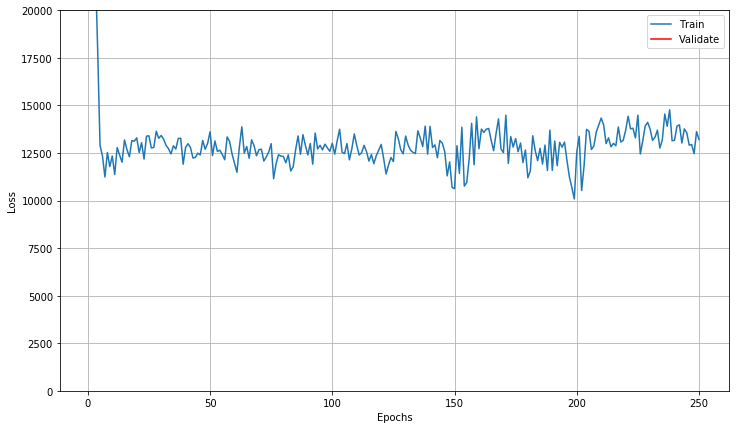

In [96]:
graph_general_loss(7,1)

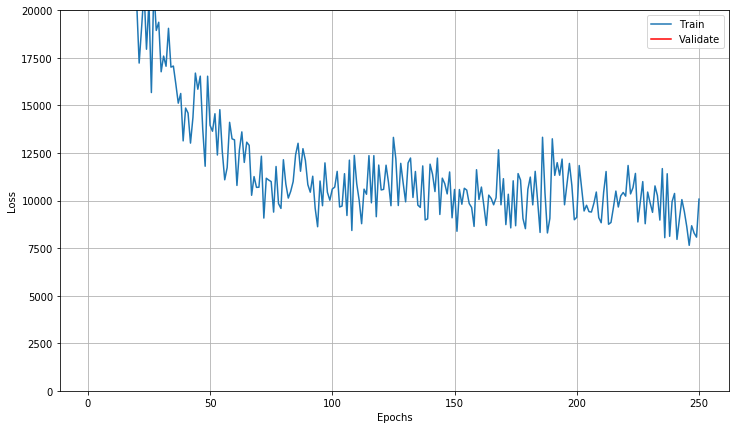

In [97]:
graph_general_loss(7,2)

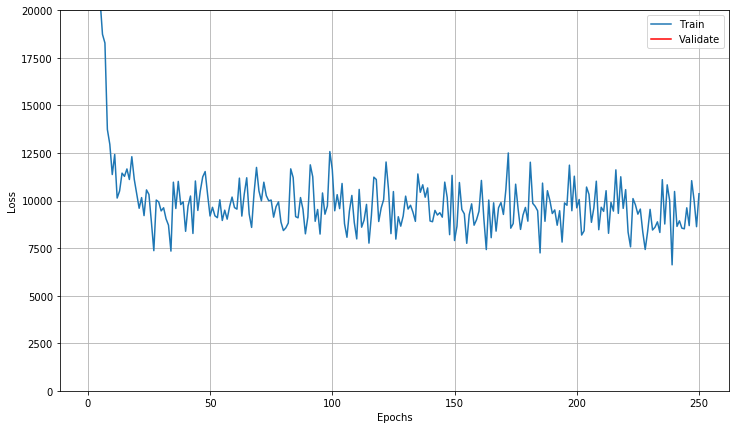

In [98]:
graph_general_loss(7,3)

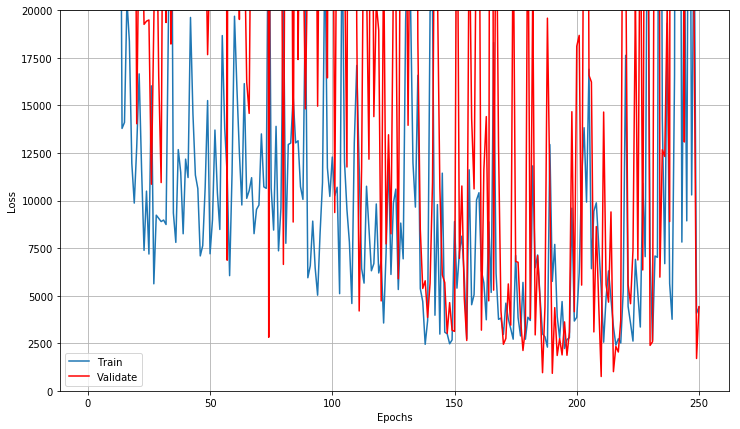

In [99]:
graph_general_loss(8,1)

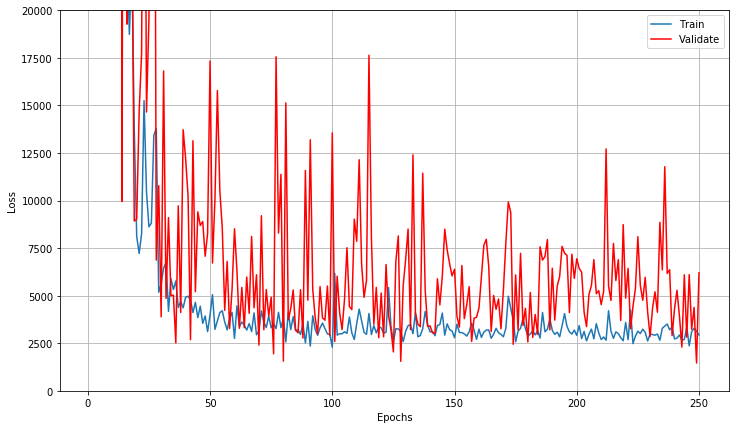

In [100]:
graph_general_loss(8,2)

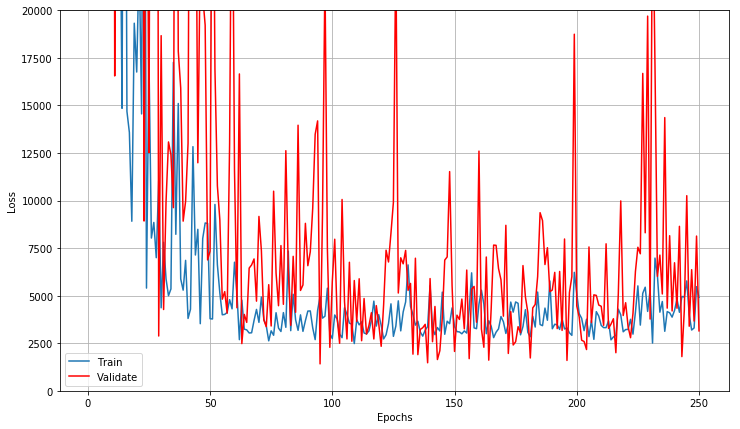

In [101]:
graph_general_loss(8,3)

In [71]:
history_M8_v3.history['loss'][-1]

4911.094012445021

In [72]:
# Function to graph individual losses according to version
def graph_individual_losses(model_num, version):
    
    if model_num == 7 and version == 1:
        history = history_M7_v1
        number = numbers[0]

    if model_num == 7 and version == 2:
        history = history_M7_v2
        number = numbers[1]
        
    if model_num == 7 and version == 3:
        history = history_M7_v3
        number = numbers[2]
        
    if model_num == 8 and version == 1:
        history = history_M8_v1
        number = numbers[3]
        
    if model_num == 8 and version == 2:
        history = history_M8_v2
        number = numbers[4]
        
    if model_num == 8 and version == 3:
        history = history_M8_v3
        number = numbers[5]
        
    #--------------------------------
    # Create plots

    plt.figure(figsize=(18,12)) 

    plt.subplot(2, 2, 1)
    plt.plot(epoch_vector, history.history['HC_loss'], label='Train')
    plt.plot(epoch_vector, history.history['val_HC_loss'], 'r', label='Dev')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    #plt.ylim((0.001,0.006))
    plt.title('HC Loss')
    plt.grid()
    plt.legend()   

    plt.subplot(2, 2, 2)
    plt.plot(epoch_vector, history.history['CO_loss'], label='Train')
    plt.plot(epoch_vector, history.history['val_CO_loss'], 'r', label='Dev')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    #plt.ylim((0.0005,0.005))
    plt.title('CO Loss')
    plt.grid()
    plt.legend()   

    plt.subplot(2, 2, 3)
    plt.plot(epoch_vector, history.history['CO2_loss'], label='Train')
    plt.plot(epoch_vector, history.history['val_CO2_loss'], 'r', label='Dev')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    #plt.ylim((0.003,0.015))
    plt.title('CO2 Loss')
    plt.grid()
    plt.legend()   

    plt.subplot(2, 2, 4)
    plt.plot(epoch_vector, history.history['NOX_loss'], label='Train')
    plt.plot(epoch_vector, history.history['val_NOX_loss'], 'r', label='Dev')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    #plt.ylim((0.0007,0.005))
    plt.title('NOX Loss')
    plt.grid()
    plt.legend()     

    plt.savefig(os.path.join(output_path,'{}_Losses-Model_{}_v{}.png'.format(number, model_num, version)), dpi=200)

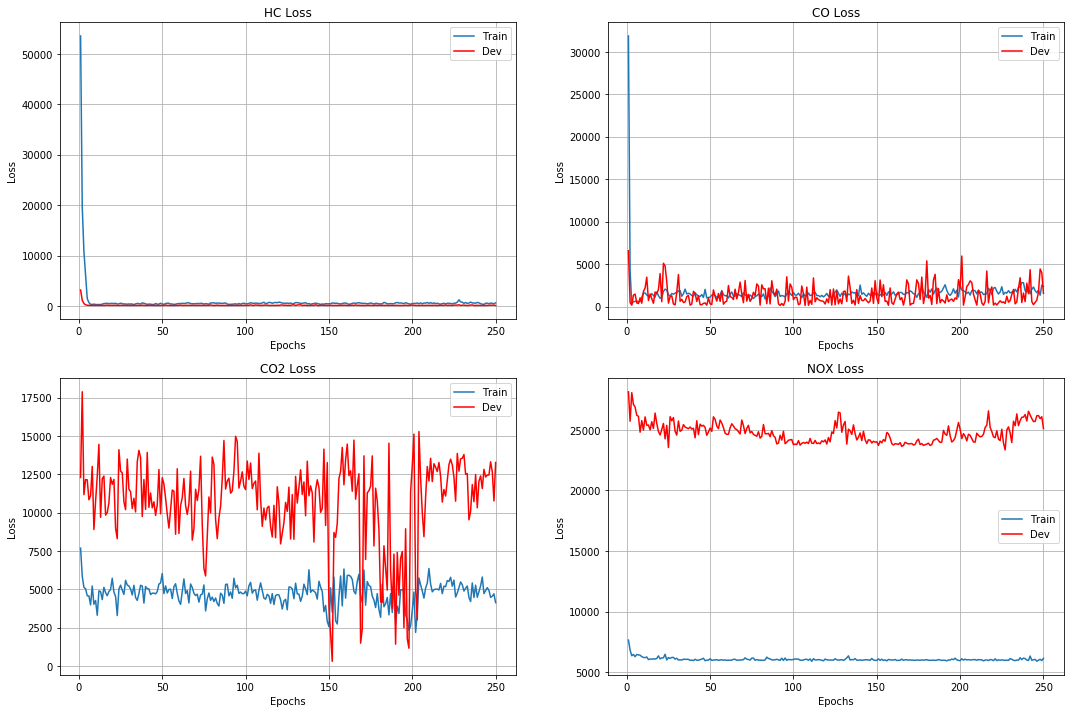

In [73]:
graph_individual_losses(7,1)

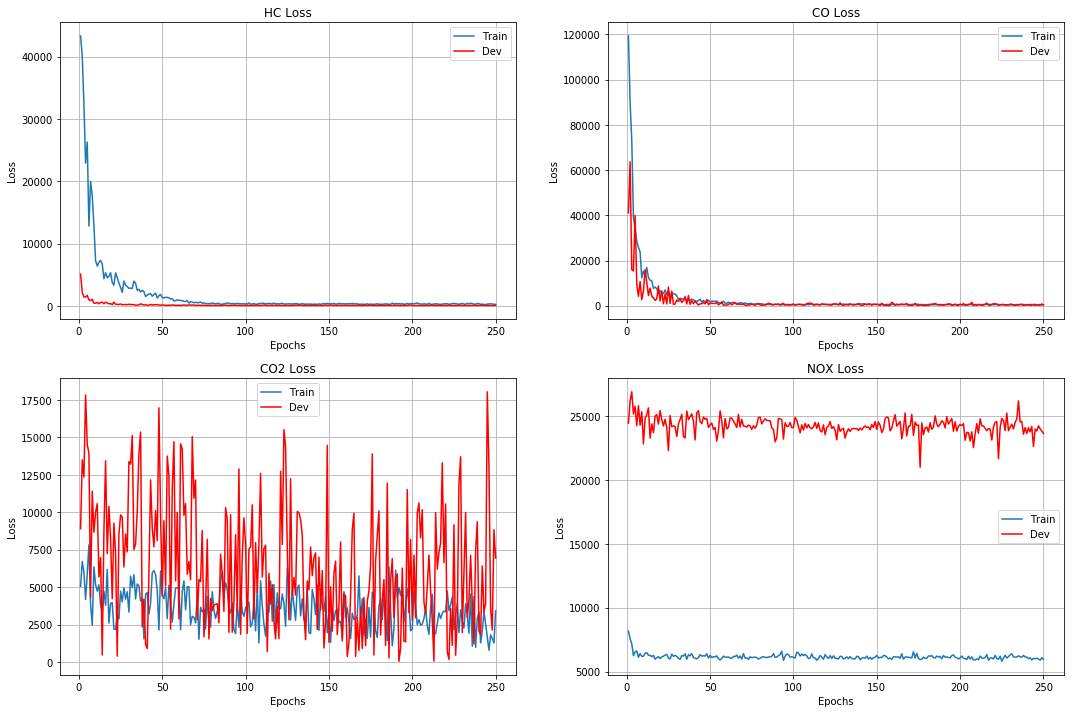

In [74]:
graph_individual_losses(7,2)

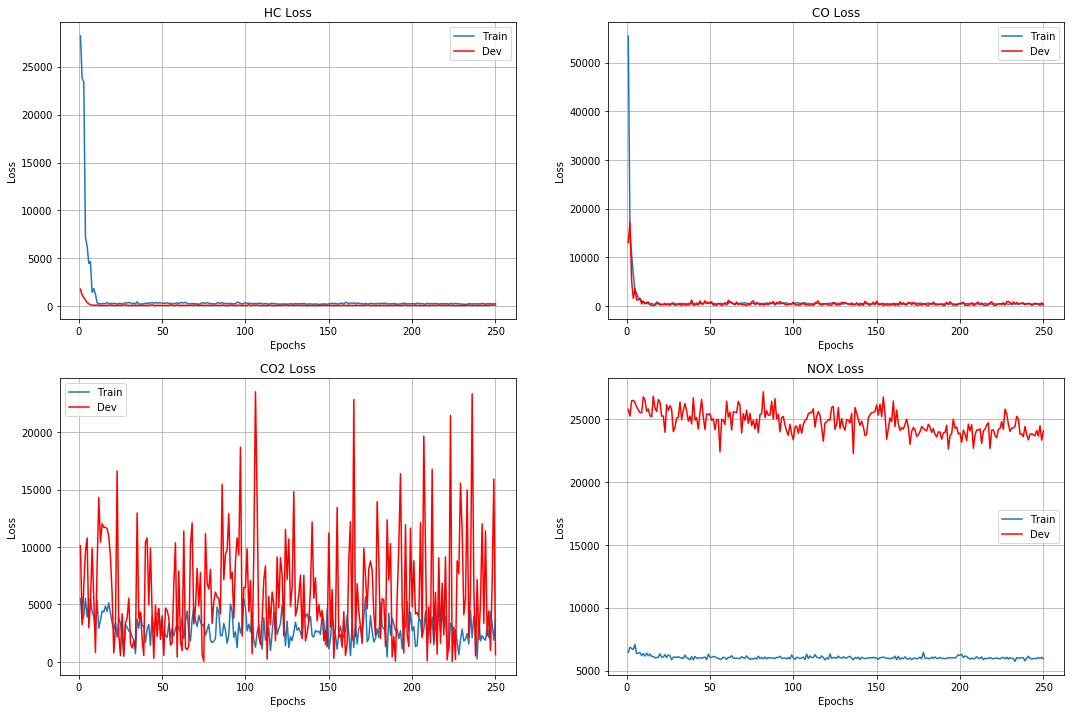

In [75]:
graph_individual_losses(7,3)

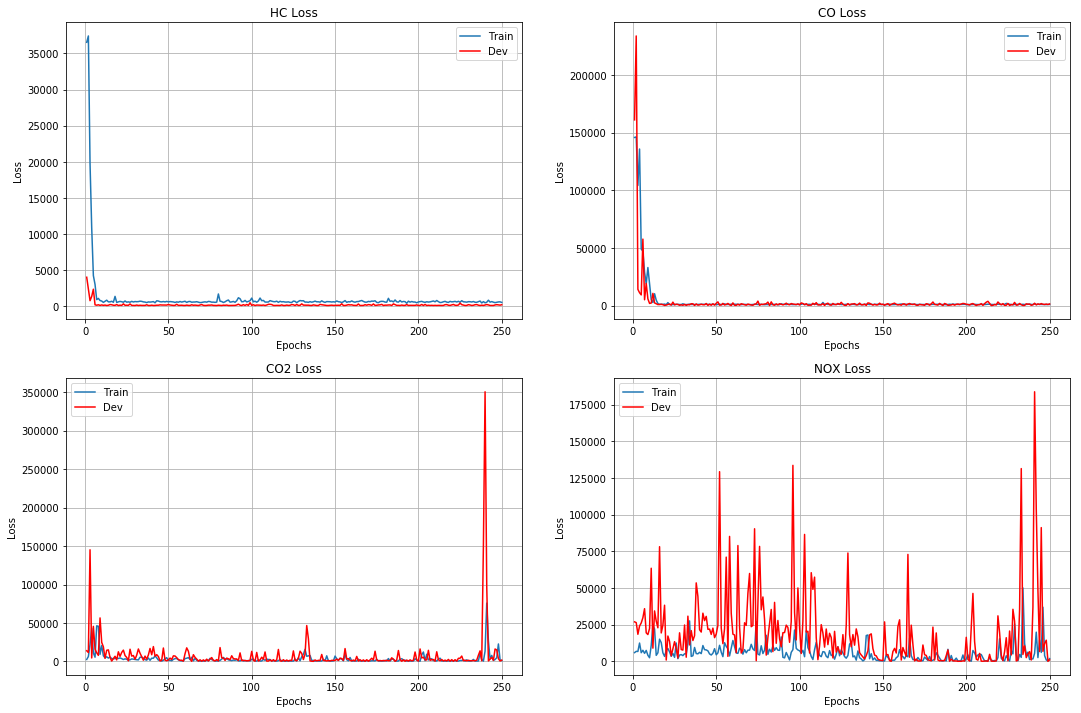

In [76]:
graph_individual_losses(8,1)

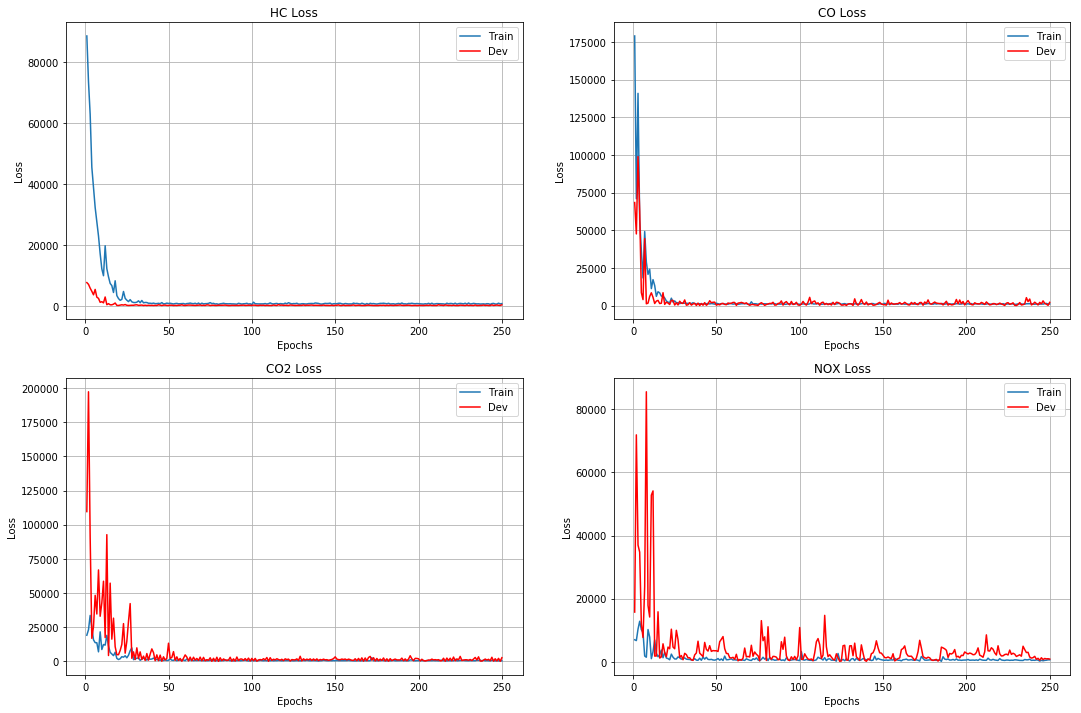

In [77]:
graph_individual_losses(8,2)

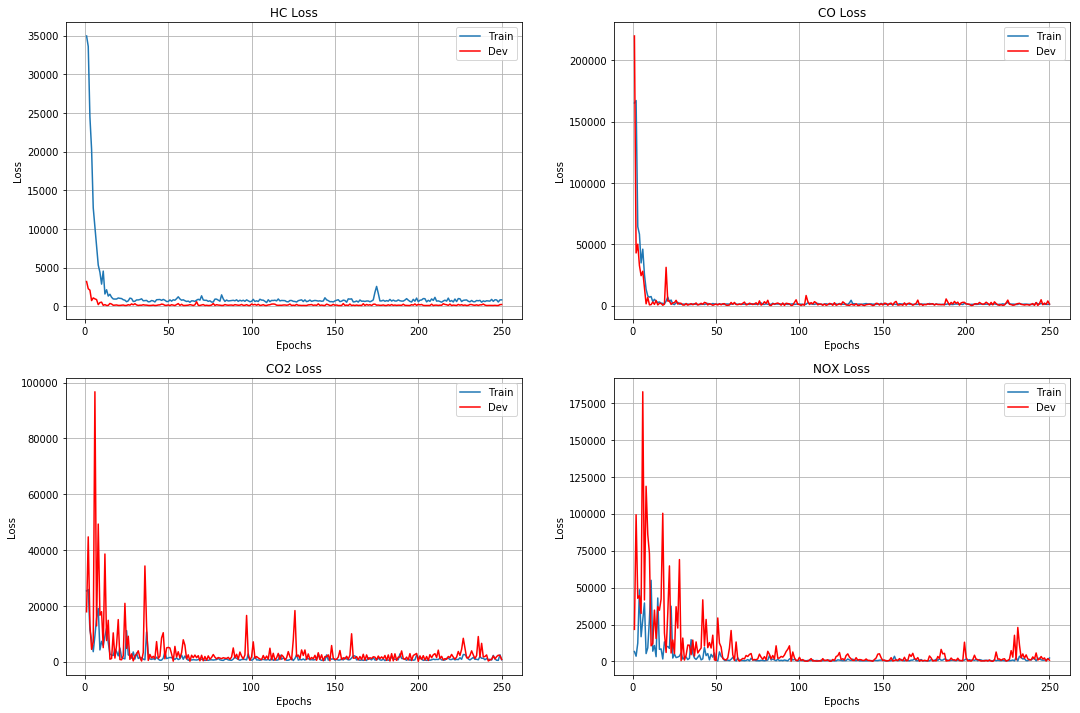

In [78]:
graph_individual_losses(8,3)

## Evaluating Models

In [79]:
# Function to evaluate models
def evaluate_models(model_num, version):
    
    if model_num == 7 and version == 1:
        model = model_7_v1

    if model_num == 7 and version == 2:
        model = model_7_v2
        
    if model_num == 7 and version == 3:
        model = model_7_v3
        
    if model_num == 8 and version == 1:
        model = model_8_v1
        
    if model_num == 8 and version == 2:
        model = model_8_v2
        
    if model_num == 8 and version == 3:
        model = model_8_v3
        
    test_history = model.evaluate(x=x_test, y=y_test, batch_size=batch_size, verbose=1)
    
    return test_history

In [80]:
test_history_M7_v1 = evaluate_models(7,1)
test_history_M7_v2 = evaluate_models(7,2)
test_history_M7_v3 = evaluate_models(7,3)
test_history_M8_v1 = evaluate_models(8,1)
test_history_M8_v2 = evaluate_models(8,2)
test_history_M8_v3 = evaluate_models(8,3)

7814/7814 [==============================] - 0s 53us/step


## Organize Losses Table

In [81]:
# Function to create tables with losses
def table_losses(model_num,version):
    
    if model_num == 7 and version == 1:
        model = model_7_v1
        history = history_M7_v1
        test_history = test_history_M7_v1

    if model_num == 7 and version == 2:
        model = model_7_v2
        history = history_M7_v2
        test_history = test_history_M7_v2
        
    if model_num == 7 and version == 3:
        model = model_7_v3
        history = history_M7_v3
        test_history = test_history_M7_v3
        
    if model_num == 8 and version == 1:
        model = model_8_v1
        history = history_M8_v1
        test_history = test_history_M8_v1
        
    if model_num == 8 and version == 2:
        model = model_8_v2
        history = history_M8_v2
        test_history = test_history_M8_v2
        
    if model_num == 8 and version == 3:
        model = model_8_v3
        history = history_M8_v3
        test_history = test_history_M8_v3
    
    # Transpose metrics to get right orientation
    metrics = np.transpose(model.metrics_names[:5])

    # Get losses for the test history
    test_history = test_history[:5]

    # Get losses for the dev history
    dev_history = [history.history["val_loss"][-1], history.history["val_HC_loss"][-1], 
                  history.history["val_CO_loss"][-1], history.history["val_CO2_loss"][-1],
                  history.history["val_NOX_loss"][-1]]

    # Get losses for the training history
    train_history = [history.history["loss"][-1], history.history["HC_loss"][-1], 
                  history.history["CO_loss"][-1], history.history["CO2_loss"][-1],
                  history.history["NOX_loss"][-1]]
    
    # Put everything together into a data frame and get right orientation
    results = pd.DataFrame([metrics, train_history, dev_history, test_history]).transpose()

    # Change column names
    results.columns = ["Metrics", "Training", "Development", "Test"]

    return results

In [82]:
results_M7_v1 = table_losses(7,1)
results_M7_v2 = table_losses(7,2)
results_M7_v3 = table_losses(7,3)
results_M8_v1 = table_losses(8,1)
results_M8_v2 = table_losses(8,2)
results_M8_v3 = table_losses(8,3)

In [83]:
results_M7_v1

,Metrics,Training,Development,Test
0,loss,13212.2,40023.2,25294.8
1,HC_loss,606.845,88.8516,400.841
2,CO_loss,2349.79,1553.56,250.197
3,CO2_loss,4123.73,13272.7,41.5629
4,NOX_loss,6131.8,25108.1,24602.2


In [84]:
results_M7_v2

,Metrics,Training,Development,Test
0,loss,10073,31069.8,24315.9
1,HC_loss,282.319,90.5913,232.145
2,CO_loss,397.666,393.885,377.344
3,CO2_loss,3426.28,6955.4,40.3939
4,NOX_loss,5966.74,23629.9,23666


In [85]:
results_M7_v3

,Metrics,Training,Development,Test
0,loss,10357.8,24941.5,24912.1
1,HC_loss,270.741,122.561,792.58
2,CO_loss,453.91,152.413,102.302
3,CO2_loss,3677.58,618.701,37.9416
4,NOX_loss,5955.6,24047.8,23979.3


In [86]:
results_M8_v1

,Metrics,Training,Development,Test
0,loss,4387.62,4421.72,3684.11
1,HC_loss,524.296,201.096,1772.32
2,CO_loss,1004.82,1452.74,834.211
3,CO2_loss,940.338,1682.88,89.9719
4,NOX_loss,1918.17,1085.01,987.608


In [87]:
results_M8_v2

,Metrics,Training,Development,Test
0,loss,2936.67,6198.86,6162.71
1,HC_loss,732.97,327.414,3869.36
2,CO_loss,1144.61,2234.78,1289.88
3,CO2_loss,443.412,2772.49,109.175
4,NOX_loss,615.677,864.179,894.294


In [88]:
results_M8_v3

,Metrics,Training,Development,Test
0,loss,4911.09,3151.07,3982.46
1,HC_loss,827.298,227.545,2323.77
2,CO_loss,1103.72,1335.79,776.259
3,CO2_loss,659.682,784.07,74.3551
4,NOX_loss,2320.39,803.664,808.072


## Save Models

In [91]:
# Function to save models
def save_model(model_num, version, loss_f):
    
    if model_num == 7 and version == 1:
        model = model_7_v1
        number = numbers[0]

    if model_num == 7 and version == 2:
        model = model_7_v2
        number = numbers[1]
        
    if model_num == 7 and version == 3:
        model = model_7_v3
        number = numbers[2]
        
    if model_num == 8 and version == 1:
        model = model_8_v1
        number = numbers[3]
        
    if model_num == 8 and version == 2:
        model = model_8_v2
        number = numbers[4]
        
    if model_num == 8 and version == 3:
        model = model_8_v3
        number = numbers[5]
        
    model.save(os.path.join(output_path,'{}_Model_{}_v{}-{}.h5'.format(number, model_num, version, loss_f)))

In [92]:
save_model(7,1, 'ReLU')
save_model(7,2, 'LReLU')
save_model(7,3, 'PReLU')
save_model(8,1, 'ReLU')
save_model(8,2, 'LReLU')
save_model(8,3, 'PReLU')

## Save Training History

In [93]:
# Function to graph individual losses according to version
def save_history(model_num, version):
    
    if model_num == 7 and version == 1:
        history = history_M7_v1
        number = numbers[0]

    if model_num == 7 and version == 2:
        history = history_M7_v2
        number = numbers[1]
        
    if model_num == 7 and version == 3:
        history = history_M7_v3
        number = numbers[2]
        
    if model_num == 8 and version == 1:
        history = history_M8_v1
        number = numbers[3]
        
    if model_num == 8 and version == 2:
        history = history_M8_v2
        number = numbers[4]
        
    if model_num == 8 and version == 3:
        history = history_M8_v3
        number = numbers[5]
        
    #--------------------------------
    
    hist_data = [epoch_vector, history.history['loss'], history.history['val_loss'], history.history['HC_loss'], 
                 history.history['val_HC_loss'], history.history['CO_loss'], history.history['val_CO_loss'], 
                 history.history['CO2_loss'], history.history['val_CO2_loss'], history.history['NOX_loss'], 
                 history.history['val_NOX_loss']]
    
    hist_data = pd.DataFrame(hist_data).transpose()
    
    # Change column names
    hist_data.columns = ['Epochs','loss','val_loss','HC_loss','val_HC_loss','CO_loss','val_CO_loss',
                         'CO2_loss','val_CO2_loss','NOX_loss','val_NOX_loss']
    
    hist_data.to_csv(os.path.join(output_path,'{}_History_Model_{}_v{}.csv'.format(number,model_num,version)), 
                     encoding='utf-8', index=False)

In [94]:
save_history(7,1)
save_history(7,2)
save_history(7,3)
save_history(8,1)
save_history(8,2)
save_history(8,3)